In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_instrinsics_baseline(filepath):
    with open(filepath,'r') as f:
        lines = f.readlines()
    
    cam0 = []
    cam1 = []
    cams={}
    for i,line in enumerate(lines[:2]):
        cams[i] = line[5:-1]
    
    rows = cams[0].strip('[]').split(';')
    for row in rows:
        row_elements = [float(elem) for elem in row.strip().split()]
        cam0.append(row_elements)
   
    rows = cams[1].strip('[]').split(';')
    for row in rows:
        row_elements = [float(elem) for elem in row.strip().split()]
        cam1.append(row_elements)

    cam0 = np.array(cam0)
    cam1 = np.array(cam1)
    
    baseline = float(lines[-1].split('=')[-1])
    
    return cam0,cam1,baseline

In [3]:
K1, K2 , baseline = load_instrinsics_baseline('/kaggle/input/cvassign1/Question 2 and 3 Images-20240326T173035Z-001/Question 2 and 3 Images/bike.txt')

img_left = cv2.imread('/kaggle/input/cvassign1/Question 2 and 3 Images-20240326T173035Z-001/Question 2 and 3 Images/bikeL.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('/kaggle/input/cvassign1/Question 2 and 3 Images-20240326T173035Z-001/Question 2 and 3 Images/bikeR.png', cv2.IMREAD_GRAYSCALE)

In [4]:
def compute_disparity_map(left_img, right_img, num_disparities=16, block_size=15):
    height, width = left_img.shape
    disparity_map = np.zeros_like(left_img, dtype=np.float32)
    half_block = block_size // 2
    
    for y in range(half_block, height - half_block):
        for x in range(half_block, width - half_block - num_disparities):
            block_left = left_img[y - half_block:y + half_block + 1,x - half_block:x + half_block + 1]
            best_match_x = block_matching(block_left, right_img, x,y, half_block, num_disparities)
            disparity_map[y, x] = x - best_match_x
            
    return disparity_map

def block_matching(block_left, right_img, x,y, half_block, num_disparities):
    best_match_x = -1
    min_cost = float('inf')

    for d in range(num_disparities):
        x_right = x - d
        if x_right < half_block:
            break
        block_right = right_img[y - half_block:y + half_block + 1,x_right - half_block:x_right + half_block + 1]
        cost = np.sum((block_left - block_right) ** 2)
        if cost < min_cost:
            min_cost = cost
            best_match_x = x_right

    return best_match_x


def compute_depth_map(disparity_map, focal_length, baseline):
    depth_map = np.zeros_like(disparity_map, dtype=np.float32)
    depth_map[disparity_map > 0] = focal_length * baseline / disparity_map[disparity_map > 0]
    return depth_map

def stereo_reconstruction(left_img, right_img, intrinsic_matrix_left, intrinsic_matrix_right, baseline, num_disparities=16, block_size=3):
    disparity_map = compute_disparity_map(left_img, right_img, num_disparities, block_size)
    depth_map = compute_depth_map(disparity_map, intrinsic_matrix_left[0, 0], baseline)
    return disparity_map, depth_map

disparity_map, depth_map = stereo_reconstruction(img_left,img_right, K1, K2, baseline, num_disparities=16, block_size=3)

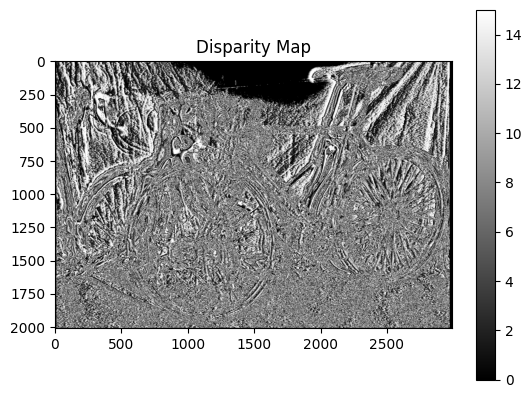

In [5]:
plt.imshow(disparity_map, cmap='gray')
plt.colorbar()
plt.title('Disparity Map')
plt.show()

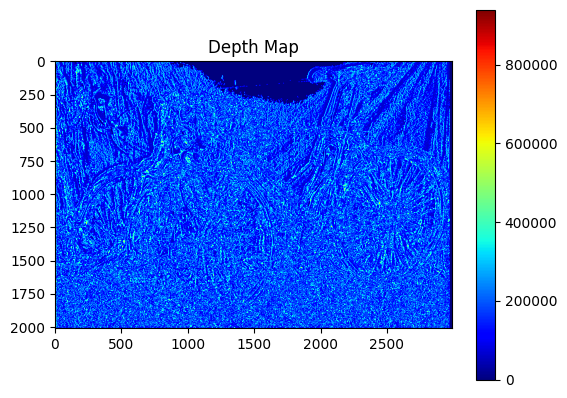

In [6]:
plt.imshow(depth_map, cmap='jet')
plt.colorbar()
plt.title('Depth Map')
plt.show()

In [7]:
def generate_point_cloud(disparity_map, K1, K2, baseline):
    f1 = K1[0, 0]  
    cx1 = K1[0, 2] 
    cy1 = K1[1, 2] 

    points_3d = np.zeros((disparity_map.shape[0], disparity_map.shape[1], 3), dtype=np.float32)

    for v in range(disparity_map.shape[0]):
        for u in range(disparity_map.shape[1]):
            disparity = disparity_map[v, u]
            if disparity > 0:
                depth = f1 * baseline / disparity
                x = (u - cx1) * depth / f1
                y = (v - cy1) * depth / f1
                z = depth
                points_3d[v, u] = [x, y, z]

    return points_3d

point_cloud = generate_point_cloud(disparity_map, K1, K2, baseline)

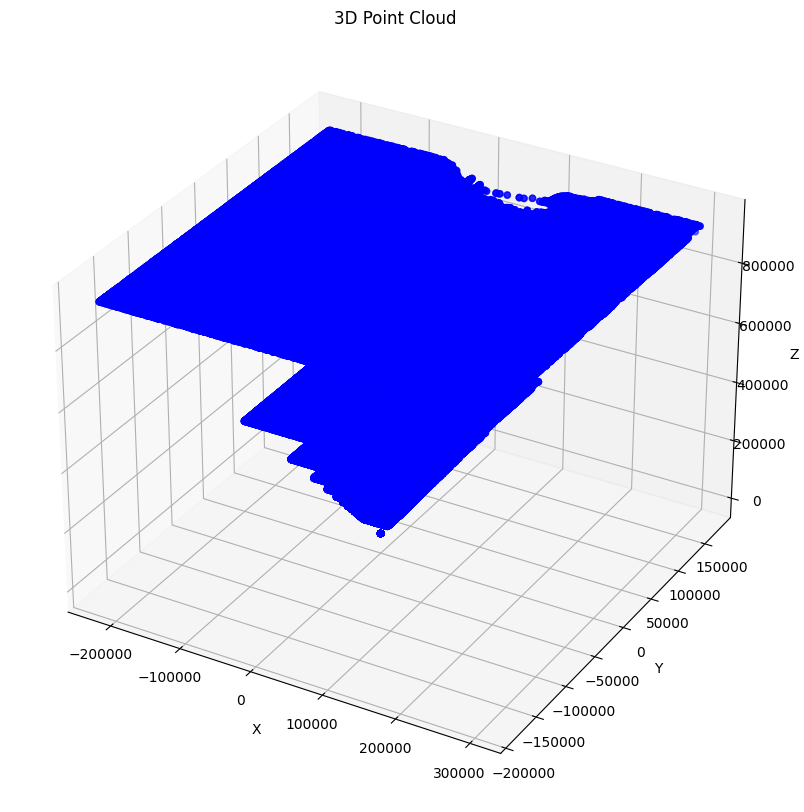

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

points = point_cloud.reshape(-1, 3)

ax.scatter(points[:, 0], -points[:, 1], points[:, 2], c='b', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud')

plt.show()